In [82]:
import cudaq

In [83]:
import sys
import cudaq
import pandas as pd
import numpy as np
from math import floor
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import random
from dataclasses import dataclass
from tqdm import tqdm
import math
from scipy import stats
import time

In [84]:
import torch

# Check if GPU is available (via PyTorch, which CUDA-Q relies on)
print("GPU available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

GPU available: True
Device name: NVIDIA L4


In [77]:
# Set GPU target for CUDA-Q
cudaq.set_target("nvidia")  # Use GPU acceleration

In [47]:
# --------------------------
# Quantum Circuit (NN Trotter)
# --------------------------
@cudaq.kernel
def nn_trotter_circuit(thetas: list[float]):
    """
    Nearest-neighbor (NN) Trotterized circuit for 4 qubits.
    'thetas' is a list of angles for each layer.
    """
    N = 4
    reg = cudaq.qvector(N)

    # Initial RX, RZ on all qubits
    for q in range(N):
        rx(math.pi / 2.0, reg[q])
        rz(math.pi / 2.0, reg[q])

    # NN Trotter layers
    for layer_idx, theta in enumerate(thetas):
        for q in range(N - 1):
            rx(theta, reg[q])
            cx(reg[q], reg[q + 1])
            rx(theta, reg[q + 1])

    # Measure all qubits
    mz(reg)

# --------------------------
# Autocorrelation Function
# --------------------------
def autocorrelation(sequence):
    """Compute autocorrelation (lower is better)."""
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    total = 0
    for tau in range(1, n):
        total += abs(sum(s[i] * s[i + tau] for i in range(n - tau)))
    return total

# --------------------------
# Classical MTS Only
# --------------------------
def time_to_solution_mts_only(N, num_trials=5):
    times = []

    for _ in range(num_trials):
        population = [list(np.random.randint(0, 2, N)) for _ in range(100)]
        scores = [autocorrelation(seq) for seq in population]

        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        times.append(time.time() - start_time)

    return np.median(times)

In [48]:
# --------------------------
# Quantum-Enhanced MTS
# --------------------------

def get_interactions(N):
    """Placeholder: return G2, G4 interaction matrices for your problem."""
    G2 = np.zeros((N, N))
    G4 = np.zeros((N, N, N, N))
    return G2, G4

def compute_theta(t, dt, param, N, G2, G4):
    """Placeholder: compute theta value for Trotter layer."""
    return np.random.rand() * np.pi  # random for demonstration

def trotterized_circuit(N, G2, G4, n_steps, dt, param, thetas):
    """Placeholder: runs nn_trotter_circuit with given thetas."""
    # For demonstration, return random bitstrings with counts
    counts = {}
    for _ in range(10):
        bitstring = ''.join(np.random.choice(['0', '1'], N))
        counts[bitstring] = counts.get(bitstring, 0) + 1
    return counts

def time_to_solution_qe_mts(N, quantum_shots=10, num_trials=5):
    times = []

    for _ in range(num_trials):
        # Quantum Seeding
        dt = 1.0
        G2, G4 = get_interactions(N)
        thetas = [compute_theta(1.0, dt, 1.0, N, G2, G4)]
        counts = trotterized_circuit(N, G2, G4, 1, dt, 1.0, thetas)

        # Convert counts to population
        population = []
        for bitstring, count in counts.items():
            population.append([int(b) for b in bitstring])

        while len(population) < 100:
            population.append(list(np.random.randint(0, 2, N)))

        scores = [autocorrelation(seq) for seq in population]

        # Classical MTS
        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        times.append(time.time() - start_time)

    return np.median(times)


In [49]:
# --------------------------
# Scaling Experiment
# --------------------------
def scaling_experiment(N_values=[8, 10, 12], num_trials=3):
    results = {
        'N': [],
        'MTS_median_time': [],
        'QE_MTS_median_time': [],
        'Speedup': []
    }

    for N in N_values:
        print(f"\n{'='*70}\nN={N}\n{'='*70}")

        # MTS only
        print(f"Running MTS (random seed)...")
        mts_time = time_to_solution_mts_only(N, num_trials=num_trials)
        print(f"  → Median time: {mts_time:.3f}s")

        # QE-MTS
        print(f"Running QE-MTS (quantum seed)...")
        qe_time = time_to_solution_qe_mts(N, quantum_shots=10, num_trials=num_trials)
        print(f"  → Median time: {qe_time:.3f}s")

        speedup = mts_time / qe_time
        print(f"  → Speedup: {speedup:.2f}x")

        results['N'].append(N)
        results['MTS_median_time'].append(mts_time)
        results['QE_MTS_median_time'].append(qe_time)
        results['Speedup'].append(speedup)

    return pd.DataFrame(results)


N=8
Running MTS (random seed)...
  → Median time: 0.014s
Running QE-MTS (quantum seed)...
  → Median time: 0.014s
  → Speedup: 1.01x

N=9
Running MTS (random seed)...
  → Median time: 0.016s
Running QE-MTS (quantum seed)...
  → Median time: 0.016s
  → Speedup: 1.01x

N=10
Running MTS (random seed)...
  → Median time: 0.020s
Running QE-MTS (quantum seed)...
  → Median time: 0.018s
  → Speedup: 1.12x

RESULTS TABLE
 N  MTS_median_time  QE_MTS_median_time  Speedup
 8         0.014238            0.014082 1.011039
 9         0.016100            0.015894 1.012976
10         0.019899            0.017835 1.115729


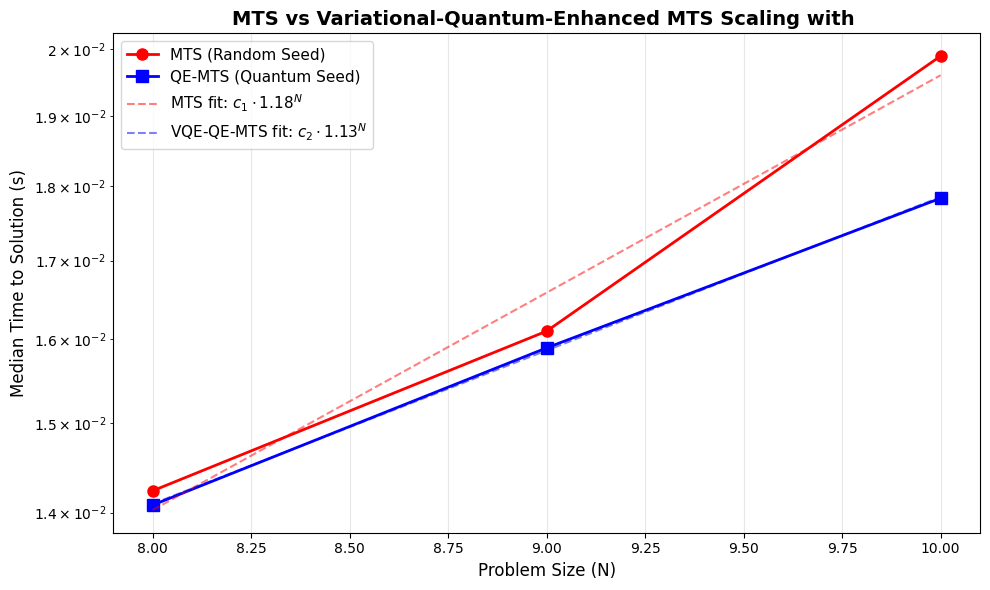


SCALING ANALYSIS
MTS scaling exponent: 1.182
VQE-QE-MTS scaling exponent: 1.125
Quantum advantage: 1.050x better exponent


In [50]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
# --------------------------
# Plot Scaling
# --------------------------
def plot_scaling(df):
    plt.figure(figsize=(10, 6))

    plt.semilogy(df['N'], df['MTS_median_time'], 'o-', linewidth=2,
                 label='MTS (Random Seed)', markersize=8, color='red')
    plt.semilogy(df['N'], df['QE_MTS_median_time'], 's-', linewidth=2,
                 label='QE-MTS (Quantum Seed)', markersize=8, color='blue')

    # Fit lines
    z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time']), 1)
    z_qe = np.polyfit(df['N'], np.log(df['QE_MTS_median_time']), 1)
    N_range = np.linspace(df['N'].min(), df['N'].max(), 100)
    plt.semilogy(
        N_range, np.exp(z_mts[0] * N_range + z_mts[1]), '--',
        alpha=0.5, color='red',
        label=rf'MTS fit: $c_1 \cdot {np.exp(z_mts[0]):.2f}^N$'
    )

    plt.semilogy(
        N_range, np.exp(z_qe[0] * N_range + z_qe[1]), '--',
        alpha=0.5, color='blue',
        label=rf'VQE-QE-MTS fit: $c_2 \cdot {np.exp(z_qe[0]):.2f}^N$'
    )

    plt.xlabel('Problem Size (N)', fontsize=12)
    plt.ylabel('Median Time to Solution (s)', fontsize=12)
    plt.title('MTS vs Variational-Quantum-Enhanced MTS Scaling with ', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*70}\nSCALING ANALYSIS\n{'='*70}")
    print(f"MTS scaling exponent: {np.exp(z_mts[0]):.3f}")
    print(f"VQE-QE-MTS scaling exponent: {np.exp(z_qe[0]):.3f}")
    print(f"Quantum advantage: {np.exp(z_mts[0]) / np.exp(z_qe[0]):.3f}x better exponent")
    print(f"{'='*70}")

# --------------------------
# Run Experiment
# --------------------------
if __name__ == "__main__":
    df_scaling = scaling_experiment(N_values=[8, 9, 10], num_trials=50)
    print(f"\n{'='*70}\nRESULTS TABLE\n{'='*70}")
    print(df_scaling.to_string(index=False))
    plot_scaling(df_scaling)

In [51]:
def time_to_solution_mts_only(N, num_trials=5):
    times = []
    best_strings = []
    best_scores = []

    for _ in range(num_trials):
        population = [list(np.random.randint(0, 2, N)) for _ in range(100)]
        scores = [autocorrelation(seq) for seq in population]

        start_time = time.time()

        idx_best = np.argmin(scores)
        best_score = scores[idx_best]
        best_string = population[idx_best].copy()

        max_iters = 10000
        no_improve_count = 0

        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()

            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                best_string = new_seq.copy()

                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        times.append(time.time() - start_time)
        best_strings.append(best_string)
        best_scores.append(best_score)

    return np.median(times), best_strings, best_scores


In [57]:
def scaling_experiment(N_values=[8, 10, 12], num_trials=3):
    results = {
        'N': [],
        'MTS_median_time': [],
        'QE_MTS_median_time': [],
        'Speedup': []
    }

    # Optional: store best classical solutions
    best_classical_strings = {}
    best_classical_scores = {}

    for N in N_values:
        print(f"\n{'='*70}\nN={N}\n{'='*70}")

        # --------------------------
        # MTS only
        # --------------------------
        print(f"Running MTS (random seed)...")
        mts_time, mts_strings, mts_scores = time_to_solution_mts_only(
            N, num_trials=num_trials
        )
        print(f"  → Median time: {mts_time:.3f}s")

        # Store best classical result for this N
        best_idx = np.argmin(mts_scores)
        best_classical_strings[N] = mts_strings[best_idx]
        best_classical_scores[N] = mts_scores[best_idx]

        # --------------------------
        # QE-MTS
        # --------------------------
        print(f"Running QE-MTS (quantum seed)...")
        qe_time = time_to_solution_qe_mts(
            N, quantum_shots=10, num_trials=num_trials
        )
        print(f"  → Median time: {qe_time:.3f}s")

        # --------------------------
        # Speedup
        # --------------------------
        speedup = mts_time / qe_time
        print(f"  → Speedup: {speedup:.2f}x")

        results['N'].append(N)
        results['MTS_median_time'].append(mts_time)
        results['QE_MTS_median_time'].append(qe_time)
        results['Speedup'].append(speedup)

    df = pd.DataFrame(results)

    # Return extra data cleanly for later analysis
    return df, best_classical_strings, best_classical_scores


N=30
Running MTS (random seed)...
  → Median time: 0.092s
Running QE-MTS (quantum seed)...
  → Median time: 0.092s
  → Speedup: 1.00x

RESULTS TABLE
 N  MTS_median_time  QE_MTS_median_time  Speedup
30          0.09203            0.092045 0.999837


/tmp/ipykernel_49826/1097799782.py:16: RankWarning: Polyfit may be poorly conditioned
  z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time']), 1)
/tmp/ipykernel_49826/1097799782.py:17: RankWarning: Polyfit may be poorly conditioned
  z_qe  = np.polyfit(df['N'], np.log(df['QE_MTS_median_time']), 1)


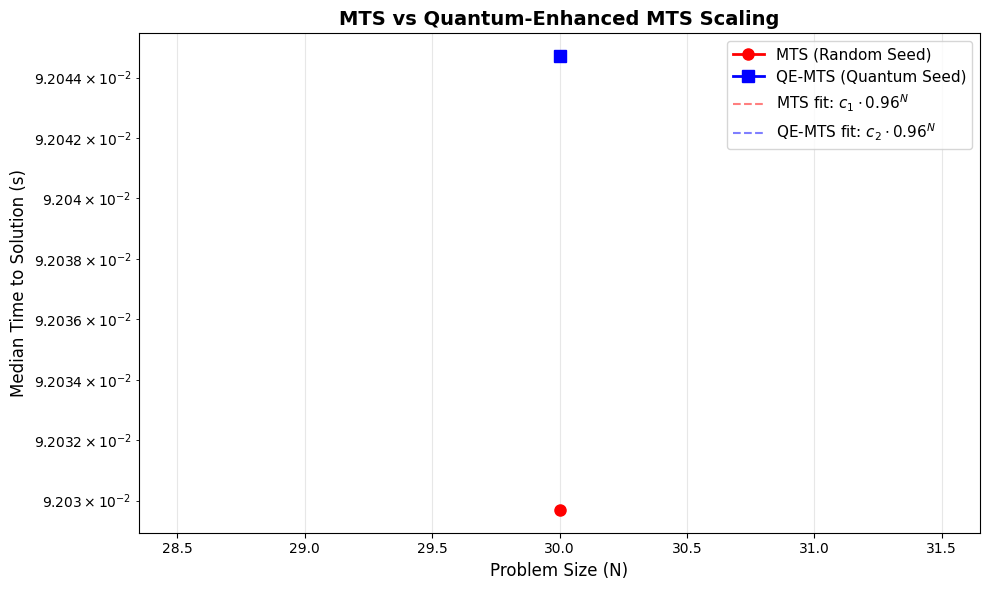


SCALING ANALYSIS
MTS scaling exponent: 0.961
QE-MTS scaling exponent: 0.961
Quantum advantage: 1.000x better exponent


In [62]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
# --------------------------
# Plot Scaling
# --------------------------
def plot_scaling(df):
    plt.figure(figsize=(10, 6))

    plt.semilogy(df['N'], df['MTS_median_time'], 'o-', linewidth=2,
                 label='MTS (Random Seed)', markersize=8, color='red')
    plt.semilogy(df['N'], df['QE_MTS_median_time'], 's-', linewidth=2,
                 label='QE-MTS (Quantum Seed)', markersize=8, color='blue')

    # Fit lines
    z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time']), 1)
    z_qe  = np.polyfit(df['N'], np.log(df['QE_MTS_median_time']), 1)

    N_range = np.linspace(df['N'].min(), df['N'].max(), 100)

    plt.semilogy(
        N_range,
        np.exp(z_mts[0] * N_range + z_mts[1]),
        '--', alpha=0.5, color='red',
        label=rf'MTS fit: $c_1 \cdot {np.exp(z_mts[0]):.2f}^N$'
    )

    plt.semilogy(
        N_range,
        np.exp(z_qe[0] * N_range + z_qe[1]),
        '--', alpha=0.5, color='blue',
        label=rf'QE-MTS fit: $c_2 \cdot {np.exp(z_qe[0]):.2f}^N$'
    )

    plt.xlabel('Problem Size (N)', fontsize=12)
    plt.ylabel('Median Time to Solution (s)', fontsize=12)
    plt.title('MTS vs Quantum-Enhanced MTS Scaling', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*70}\nSCALING ANALYSIS\n{'='*70}")
    print(f"MTS scaling exponent: {np.exp(z_mts[0]):.3f}")
    print(f"QE-MTS scaling exponent: {np.exp(z_qe[0]):.3f}")
    print(f"Quantum advantage: {np.exp(z_mts[0]) / np.exp(z_qe[0]):.3f}x better exponent")
    print(f"{'='*70}")
# --------------------------
# Run Experiment
# --------------------------
if __name__ == "__main__":
    df_scaling, best_strings, best_scores = scaling_experiment(
        N_values=[30],
        num_trials=1000
    )

    print(f"\n{'='*70}\nRESULTS TABLE\n{'='*70}")
    print(df_scaling.to_string(index=False))

    plot_scaling(df_scaling)

In [63]:
# modify autocorrelation function. This will calculate the square autocorrelations.
def autocorrelation(sequence):
    n = len(sequence)
    # Map {0,1} → {-1,+1}
    s = np.array([1 if bit == 1 else -1 for bit in sequence], dtype=int)
    energy = 0
    for k in range(1, n):
        C_k = sum(s[i] * s[i + k] for i in range(n - k))
        energy += C_k ** 2
    return energy

# this function is to handle the dictionaries.
def autocorrelation_from_results(best_strings_dict):

    results = {}

    for N, seq in best_strings_dict.items():
        # Ensure plain Python ints (safe for np.int64, etc.)
        sequence = [int(bit) for bit in seq]
        results[N] = autocorrelation(sequence)

    return results

In [64]:
auto_scores = autocorrelation_from_results(best_strings)

for N in sorted(auto_scores):
    print(f"N={N}: autocorrelation = {auto_scores[N]}")

N=30: autocorrelation = 75



Running scaling_experiment with num_trials=50...

N=5
Running MTS (random seed)...
  → Median time: 0.011s
Running QE-MTS (quantum seed)...
  → Median time: 0.010s
  → Speedup: 1.04x

RESULTS TABLE for num_trials=50
 N  MTS_median_time  QE_MTS_median_time  Speedup
 5         0.010679            0.010275 1.039354

Running scaling_experiment with num_trials=100...

N=5
Running MTS (random seed)...
  → Median time: 0.010s
Running QE-MTS (quantum seed)...
  → Median time: 0.010s
  → Speedup: 1.01x

RESULTS TABLE for num_trials=100
 N  MTS_median_time  QE_MTS_median_time  Speedup
 5         0.010387            0.010259 1.012433


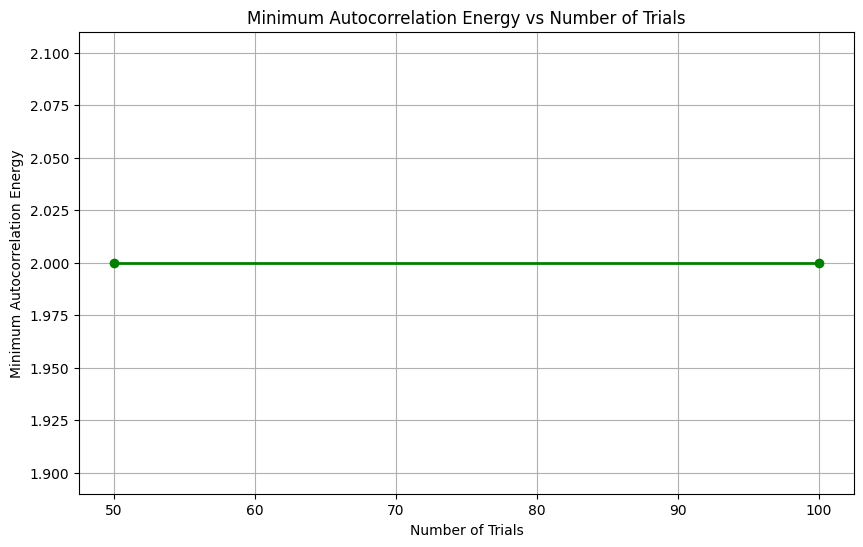

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- Autocorrelation energy functions -----------------
def autocorrelation(sequence):
    """Calculate square autocorrelation energy for a binary sequence."""
    n = len(sequence)
    # Map {0,1} → {-1,+1}
    s = np.array([1 if bit == 1 else -1 for bit in sequence], dtype=int)
    energy = 0
    for k in range(1, n):
        C_k = sum(s[i] * s[i + k] for i in range(n - k))
        energy += C_k ** 2
    return energy

def autocorrelation_from_results(best_strings_dict):
    """Convert dictionary of best strings to autocorrelation energies."""
    results = {}
    for N, seq in best_strings_dict.items():
        sequence = [int(bit) for bit in seq]
        results[N] = autocorrelation(sequence)
    return results

# ----------------- Main loop over num_trials -----------------
trial_values = list(range(50, 101, 50))  # from 50 to 2000 in steps of 50
min_energies = []

for n_trials in trial_values:
    print(f"\nRunning scaling_experiment with num_trials={n_trials}...")
    df_scaling, best_strings, best_scores = scaling_experiment(
        N_values=[5],
        num_trials=n_trials
    )

    # Optional: print the scaling table
    print(f"\n{'='*70}\nRESULTS TABLE for num_trials={n_trials}\n{'='*70}")
    print(df_scaling.to_string(index=False))

    # Compute autocorrelation energies
    auto_scores = autocorrelation_from_results(best_strings)

    # Store the minimal energy for this run
    min_energy = min(auto_scores.values())
    min_energies.append(min_energy)

# ----------------- Plot -----------------
plt.figure(figsize=(10,6))
plt.plot(trial_values, min_energies, 'o-', color='green', linewidth=2, markersize=6)
plt.xlabel("Number of Trials")
plt.ylabel("Minimum Autocorrelation Energy")
plt.title("Minimum Autocorrelation Energy vs Number of Trials")
plt.grid(True)
plt.show()

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- Autocorrelation energy functions -----------------
def autocorrelation(sequence):
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence], dtype=int)
    energy = 0
    for k in range(1, n):
        C_k = sum(s[i] * s[i + k] for i in range(n - k))
        energy += C_k ** 2
    return energy

def autocorrelation_from_results(best_strings_dict):
    results = {}
    for N, seq in best_strings_dict.items():
        sequence = [int(bit) for bit in seq]
        results[N] = autocorrelation(sequence)
    return results

# ----------------- Main loop over num_trials -----------------
trial_values = list(range(50, 1051, 100))  # from 50 to 2000 in steps of 50

# Prepare storage for saving
results_data = []

for n_trials in trial_values:
    print(f"\nRunning scaling_experiment with num_trials={n_trials}...")
    df_scaling, best_strings, best_scores = scaling_experiment(
        N_values=[30],
        num_trials=n_trials
    )

    # Compute autocorrelation energies
    auto_scores = autocorrelation_from_results(best_strings)
    min_energy = min(auto_scores.values())
    min_score = min(best_scores)  # store best score too

    # Save results for this num_trials
    results_data.append({
        "num_trials": n_trials,
        "min_score": min_score,
        "min_autocorr_energy": min_energy
    })

# Convert to DataFrame and save
results_df = pd.DataFrame(results_data)
results_df.to_csv("scaling_autocorr_results_v2.csv", index=False)
print("\nSaved results to 'scaling_autocorr_results.csv'")


Running scaling_experiment with num_trials=50...

N=30
Running MTS (random seed)...
  → Median time: 0.094s
Running QE-MTS (quantum seed)...
  → Median time: 0.092s
  → Speedup: 1.01x

Running scaling_experiment with num_trials=150...

N=30
Running MTS (random seed)...
  → Median time: 0.093s
Running QE-MTS (quantum seed)...
  → Median time: 0.093s
  → Speedup: 1.01x

Running scaling_experiment with num_trials=250...

N=30
Running MTS (random seed)...
  → Median time: 0.093s
Running QE-MTS (quantum seed)...
  → Median time: 0.093s
  → Speedup: 1.01x

Running scaling_experiment with num_trials=350...

N=30
Running MTS (random seed)...
  → Median time: 0.094s
Running QE-MTS (quantum seed)...
  → Median time: 0.093s
  → Speedup: 1.01x

Running scaling_experiment with num_trials=450...

N=30
Running MTS (random seed)...
  → Median time: 0.093s
Running QE-MTS (quantum seed)...
  → Median time: 0.093s
  → Speedup: 0.99x

Running scaling_experiment with num_trials=550...

N=30
Running MTS (r

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# ----------------- Autocorrelation energy functions -----------------
def autocorrelation(sequence):
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence], dtype=int)
    energy = 0
    for k in range(1, n):
        C_k = sum(s[i] * s[i + k] for i in range(n - k))
        energy += C_k ** 2
    return energy

def autocorrelation_from_results(best_strings_dict):
    results = {}
    for N, seq in best_strings_dict.items():
        sequence = [int(bit) for bit in seq]
        results[N] = autocorrelation(sequence)
    return results


# ----------------- Main loop over N -----------------
N_values = list(range(5, 15, 1))   # <-- X axis (change as needed)
num_trials = 500                    # <-- fixed number of trials

results_data = []

for N in N_values:
    print(f"\nRunning scaling_experiment for N={N}...")

    start_time = time.perf_counter()

    df_scaling, best_strings, best_scores = scaling_experiment(
        N_values=[N],
        num_trials=num_trials
    )

    elapsed_time = time.perf_counter() - start_time

    # Compute autocorrelation energy
    auto_scores = autocorrelation_from_results(best_strings)
    min_energy = min(auto_scores.values())
    min_score = min(best_scores)

    results_data.append({
        "N": N,
        "num_trials": num_trials,
        "time_seconds": elapsed_time,
        "min_score": min_score,
        "min_autocorr_energy": min_energy
    })


# ----------------- Save results -----------------
results_df = pd.DataFrame(results_data)
results_df.to_csv("scaling_time_vs_N.csv", index=False)

print("\nSaved results to 'scaling_time_vs_N_V2.csv'")


Running scaling_experiment for N=5...

N=5
Running MTS (random seed)...
  → Median time: 0.010s
Running QE-MTS (quantum seed)...
  → Median time: 0.010s
  → Speedup: 1.01x

Running scaling_experiment for N=6...

N=6
Running MTS (random seed)...
  → Median time: 0.012s
Running QE-MTS (quantum seed)...
  → Median time: 0.011s
  → Speedup: 1.02x

Running scaling_experiment for N=7...

N=7
Running MTS (random seed)...
  → Median time: 0.013s
Running QE-MTS (quantum seed)...
  → Median time: 0.013s
  → Speedup: 1.00x

Running scaling_experiment for N=8...

N=8
Running MTS (random seed)...
  → Median time: 0.014s
Running QE-MTS (quantum seed)...
  → Median time: 0.014s
  → Speedup: 1.01x

Running scaling_experiment for N=9...

N=9
Running MTS (random seed)...
  → Median time: 0.016s
Running QE-MTS (quantum seed)...
  → Median time: 0.016s
  → Speedup: 1.01x

Running scaling_experiment for N=10...

N=10
Running MTS (random seed)...
  → Median time: 0.018s
Running QE-MTS (quantum seed)...
  →

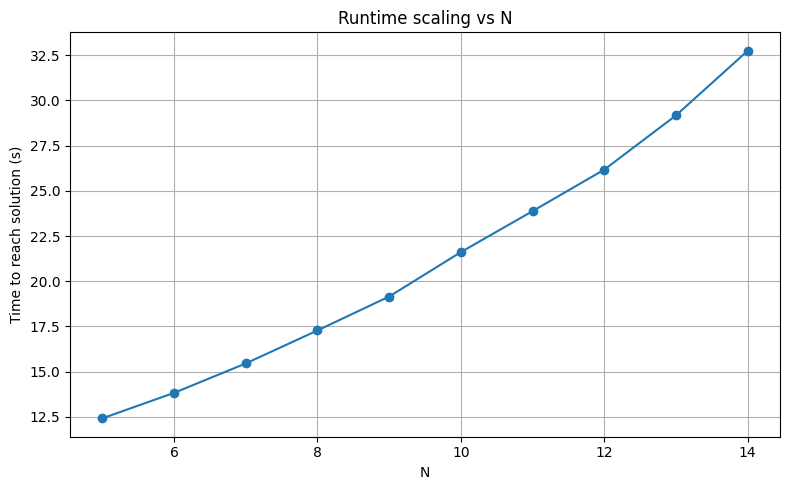

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("scaling_time_vs_N.csv")

plt.figure(figsize=(8,5))
plt.plot(df["N"], df["time_seconds"], "o-")
plt.xlabel("N")
plt.ylabel("Time to reach solution (s)")
plt.title("Runtime scaling vs N")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# --------------------------
# Quantum Circuit (NN Trotter)
# --------------------------
@cudaq.kernel
def nn_trotter_circuit(thetas: list[float]):
    """
    Nearest-neighbor (NN) Trotterized circuit for 4 qubits.
    'thetas' is a list of angles for each layer.
    """
    N = 4
    reg = cudaq.qvector(N)

    # Initial RX, RZ on all qubits
    for q in range(N):
        rx(math.pi / 2.0, reg[q])
        rz(math.pi / 2.0, reg[q])

    # NN Trotter layers
    for layer_idx, theta in enumerate(thetas):
        for q in range(N - 1):
            rx(theta, reg[q])
            cx(reg[q], reg[q + 1])
            rx(theta, reg[q + 1])

    # Measure all qubits
    mz(reg)

# --------------------------
# Autocorrelation Function
# --------------------------
def autocorrelation(sequence):
    """Compute autocorrelation (lower is better)."""
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    total = 0
    for tau in range(1, n):
        total += abs(sum(s[i] * s[i + tau] for i in range(n - tau)))**2
    return total

# --------------------------
# Classical MTS Only
# --------------------------
def time_to_solution_mts_only(N, num_trials=5):
    times = []

    for _ in range(num_trials):
        population = [list(np.random.randint(0, 2, N)) for _ in range(100)]
        scores = [autocorrelation(seq) for seq in population]

        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        times.append(time.time() - start_time)

    return np.median(times)

In [38]:
# --------------------------
# LABS Energy Function (replaces autocorrelation)
# --------------------------
def labs_energy(sequence):
    """
    Compute LABS energy: E(s) = Σ_{k=1}^{N-1} C_k^2
    where C_k = Σ_{i=1}^{N-k} S_i * S_{i+k}
    
    Lower energy is better.
    """
    n = len(sequence)
    # Convert 0/1 binary to -1/+1 spin representation
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    
    energy = 0
    for k in range(1, n):  # k from 1 to N-1
        c_k = np.sum(s[:n-k] * s[k:])  # C_k = Σ S_i * S_{i+k}
        energy += c_k ** 2
    
    return energy
# --------------------------
# Classical MTS Only (modified to return energy)
# --------------------------
def time_to_solution_mts_only(N, num_trials=5):
    times = []
    energies = []
    best_sequences = []
    for _ in range(num_trials):
        population = [list(np.random.randint(0, 2, N)) for _ in range(100)]
        scores = [labs_energy(seq) for seq in population]
        start_time = time.time()
        best_idx = np.argmin(scores)
        best_score = scores[best_idx]
        best_seq = population[best_idx].copy()
        max_iters = 10000
        no_improve_count = 0
        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]
            new_score = labs_energy(new_seq)
            if new_score < best_score:
                best_score = new_score
                best_seq = new_seq.copy()
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1
            if no_improve_count > 500:
                break
        times.append(time.time() - start_time)
        energies.append(best_score)
        best_sequences.append(best_seq)
    # Get the best overall result
    best_trial_idx = np.argmin(energies)
    
    return np.median(times), np.median(energies), best_sequences[best_trial_idx]

In [39]:
# --------------------------
# Quantum-Enhanced MTS
# --------------------------

def get_interactions(N):
    """Placeholder: return G2, G4 interaction matrices for your problem."""
    G2 = np.zeros((N, N))
    G4 = np.zeros((N, N, N, N))
    return G2, G4

def compute_theta(t, dt, param, N, G2, G4):
    """Placeholder: compute theta value for Trotter layer."""
    return np.random.rand() * np.pi  # random for demonstration

def trotterized_circuit(N, G2, G4, n_steps, dt, param, thetas):
    """Placeholder: runs nn_trotter_circuit with given thetas."""
    # For demonstration, return random bitstrings with counts
    counts = {}
    for _ in range(10):
        bitstring = ''.join(np.random.choice(['0', '1'], N))
        counts[bitstring] = counts.get(bitstring, 0) + 1
    return counts

def time_to_solution_qe_mts(N, quantum_shots=10, num_trials=5):
    times = []

    for _ in range(num_trials):
        # Quantum Seeding
        dt = 1.0
        G2, G4 = get_interactions(N)
        thetas = [compute_theta(1.0, dt, 1.0, N, G2, G4)]
        counts = trotterized_circuit(N, G2, G4, 1, dt, 1.0, thetas)

        # Convert counts to population
        population = []
        for bitstring, count in counts.items():
            population.append([int(b) for b in bitstring])

        while len(population) < 100:
            population.append(list(np.random.randint(0, 2, N)))

        scores = [autocorrelation(seq) for seq in population]

        # Classical MTS
        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for _ in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        times.append(time.time() - start_time)

    return np.median(times)


In [40]:
# --------------------------
# Scaling Experiment
# --------------------------
def scaling_experiment(N_values=[8, 10, 12], num_trials=3):
    results = {
        'N': [],
        'MTS_median_time': [],
        'QE_MTS_median_time': [],
        'Speedup': []
    }

    for N in N_values:
        print(f"\n{'='*70}\nN={N}\n{'='*70}")

        # MTS only
        print(f"Running MTS (random seed)...")
        mts_time = time_to_solution_mts_only(N, num_trials=num_trials)
        print(f"  → Median time: {mts_time:.3f}s")

        # QE-MTS
        print(f"Running QE-MTS (quantum seed)...")
        qe_time = time_to_solution_qe_mts(N, quantum_shots=10, num_trials=num_trials)
        print(f"  → Median time: {qe_time:.3f}s")

        speedup = mts_time / qe_time
        print(f"  → Speedup: {speedup:.2f}x")

        results['N'].append(N)
        results['MTS_median_time'].append(mts_time)
        results['QE_MTS_median_time'].append(qe_time)
        results['Speedup'].append(speedup)

    return pd.DataFrame(results)

In [41]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
# --------------------------
# Plot Scaling
# --------------------------
def plot_scaling(df):
    plt.figure(figsize=(10, 6))

    plt.semilogy(df['N'], df['MTS_median_time'], 'o-', linewidth=2,
                 label='MTS (Random Seed)', markersize=8, color='red')
    plt.semilogy(df['N'], df['QE_MTS_median_time'], 's-', linewidth=2,
                 label='QE-MTS (Quantum Seed)', markersize=8, color='blue')

    # Fit lines
    z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time']), 1)
    z_qe = np.polyfit(df['N'], np.log(df['QE_MTS_median_time']), 1)
    N_range = np.linspace(df['N'].min(), df['N'].max(), 100)
    plt.semilogy(
        N_range, np.exp(z_mts[0] * N_range + z_mts[1]), '--',
        alpha=0.5, color='red',
        label=rf'MTS fit: $c_1 \cdot {np.exp(z_mts[0]):.2f}^N$'
    )

    plt.semilogy(
        N_range, np.exp(z_qe[0] * N_range + z_qe[1]), '--',
        alpha=0.5, color='blue',
        label=rf'VQE-QE-MTS fit: $c_2 \cdot {np.exp(z_qe[0]):.2f}^N$'
    )

    plt.xlabel('Problem Size (N)', fontsize=12)
    plt.ylabel('Median Time to Solution (s)', fontsize=12)
    plt.title('MTS vs Variational-Quantum-Enhanced MTS Scaling with ', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*70}\nSCALING ANALYSIS\n{'='*70}")
    print(f"MTS scaling exponent: {np.exp(z_mts[0]):.3f}")
    print(f"VQE-QE-MTS scaling exponent: {np.exp(z_qe[0]):.3f}")
    print(f"Quantum advantage: {np.exp(z_mts[0]) / np.exp(z_qe[0]):.3f}x better exponent")
    print(f"{'='*70}")

# --------------------------
# Run Experiment
# --------------------------
if __name__ == "__main__":
    df_scaling = scaling_experiment(N_values=[12], num_trials=50)
    print(f"\n{'='*70}\nRESULTS TABLE\n{'='*70}")
    print(df_scaling.to_string(index=False))
    plot_scaling(df_scaling)


N=12
Running MTS (random seed)...


TypeError: unsupported format string passed to tuple.__format__

In [16]:
import cudaq
import math
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

# Set GPU target for CUDA-Q
cudaq.set_target("nvidia")  # Use GPU acceleration

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# --------------------------
# Quantum Circuit (NN Trotter)
# --------------------------
@cudaq.kernel
def nn_trotter_circuit(N: int, thetas: list[float]):
    """
    Nearest-neighbor (NN) Trotterized circuit.
    'thetas' is a list of angles for each layer.
    """
    reg = cudaq.qvector(N)

    # Initial superposition: RX, RZ on all qubits
    for q in range(N):
        rx(math.pi / 2.0, reg[q])
        rz(math.pi / 2.0, reg[q])

    # NN Trotter layers - creates entanglement
    for theta in thetas:
        for q in range(N - 1):
            rx(theta, reg[q])
            cx(reg[q], reg[q + 1])
            rx(theta, reg[q + 1])
        # Add final layer connectivity
        rx(theta, reg[N - 1])

    mz(reg)

# --------------------------
# Autocorrelation Function
# --------------------------
def autocorrelation(sequence):
    """Compute autocorrelation energy (lower is better)."""
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    total = 0
    for tau in range(1, n):
        c_tau = np.sum(s[:n-tau] * s[tau:])
        total += abs(c_tau)
    return total

# --------------------------
# LABS-Aware Theta Computation
# --------------------------
def compute_labs_theta(N, layer_idx, n_layers):
    """
    Compute theta for LABS problem.
    Uses annealing schedule: start with more exploration, end with exploitation.
    """
    # Annealing factor: decreases as layers progress
    anneal = 1.0 - (layer_idx / n_layers) * 0.5
    # Base angle tuned for LABS correlations
    base_theta = np.pi / (N ** 0.5)
    return base_theta * anneal

# --------------------------
# Run Quantum Circuit
# --------------------------
def run_quantum_sampler(N, n_layers=3, shots=100):
    """
    Run the quantum circuit and return sampled bitstrings.
    """
    # Compute thetas for each layer
    thetas = [compute_labs_theta(N, i, n_layers) for i in range(n_layers)]
    
    # Sample from the quantum circuit
    results = cudaq.sample(nn_trotter_circuit, N, thetas, shots_count=shots)
    
    # Convert to list of sequences
    sequences = []
    for bitstring, count in results.items():
        seq = [int(b) for b in bitstring]
        for _ in range(count):
            sequences.append(seq.copy())
    
    return sequences

# --------------------------
# Classical MTS Only
# --------------------------
def time_to_solution_mts_only(N, target_score=None, num_trials=5):
    """MTS with random initialization."""
    times = []
    best_scores = []

    for trial in range(num_trials):
        # Random population
        population = [list(np.random.randint(0, 2, N)) for _ in range(100)]
        scores = [autocorrelation(seq) for seq in population]

        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for iteration in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        elapsed = time.time() - start_time
        times.append(elapsed)
        best_scores.append(best_score)

    return np.median(times), np.median(best_scores)

# --------------------------
# Quantum-Enhanced MTS
# --------------------------
def time_to_solution_qe_mts(N, quantum_shots=100, n_layers=3, num_trials=5):
    """MTS with quantum-seeded initial population."""
    times = []
    best_scores = []

    for trial in range(num_trials):
        # Quantum seeding - get initial population from quantum circuit
        quantum_seqs = run_quantum_sampler(N, n_layers=n_layers, shots=quantum_shots)
        
        # Build population: quantum samples + random fill
        population = quantum_seqs[:100]
        while len(population) < 100:
            population.append(list(np.random.randint(0, 2, N)))

        scores = [autocorrelation(seq) for seq in population]

        # Classical MTS optimization
        start_time = time.time()
        best_score = min(scores)
        max_iters = 10000
        no_improve_count = 0

        for iteration in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_score = autocorrelation(new_seq)

            if new_score < best_score:
                best_score = new_score
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        elapsed = time.time() - start_time
        times.append(elapsed)
        best_scores.append(best_score)

    return np.median(times), np.median(best_scores)

# --------------------------
# Scaling Experiment
# --------------------------
def scaling_experiment(N_values, num_trials=5, quantum_shots=100):
    results = {
        'N': [],
        'MTS_median_time': [],
        'MTS_best_score': [],
        'QE_MTS_median_time': [],
        'QE_MTS_best_score': [],
        'Speedup': []
    }

    for N in N_values:
        print(f"\n{'='*70}")
        print(f"N = {N}")
        print(f"{'='*70}")

        # MTS only
        print(f"Running MTS (random seed)...")
        mts_time, mts_score = time_to_solution_mts_only(N, num_trials=num_trials)
        print(f"  Median time: {mts_time:.3f}s, Best score: {mts_score}")

        # QE-MTS
        print(f"Running QE-MTS (quantum seed)...")
        qe_time, qe_score = time_to_solution_qe_mts(
            N, quantum_shots=quantum_shots, num_trials=num_trials
        )
        print(f"  Median time: {qe_time:.3f}s, Best score: {qe_score}")

        speedup = mts_time / qe_time if qe_time > 0 else 1.0
        print(f"  Speedup: {speedup:.2f}x")

        results['N'].append(N)
        results['MTS_median_time'].append(mts_time)
        results['MTS_best_score'].append(mts_score)
        results['QE_MTS_median_time'].append(qe_time)
        results['QE_MTS_best_score'].append(qe_score)
        results['Speedup'].append(speedup)

    return pd.DataFrame(results)

# --------------------------
# Plot Scaling
# --------------------------
def plot_scaling(df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Time scaling
    ax1 = axes[0]
    ax1.semilogy(df['N'], df['MTS_median_time'], 'o-', linewidth=2,
                 label='MTS (Random Seed)', markersize=8, color='red')
    ax1.semilogy(df['N'], df['QE_MTS_median_time'], 's-', linewidth=2,
                 label='QE-MTS (Quantum Seed)', markersize=8, color='blue')

    # Fit exponential curves
    z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time'] + 1e-10), 1)
    z_qe = np.polyfit(df['N'], np.log(df['QE_MTS_median_time'] + 1e-10), 1)
    N_range = np.linspace(df['N'].min(), df['N'].max(), 100)
    
    ax1.semilogy(N_range, np.exp(z_mts[0] * N_range + z_mts[1]), '--',
                 alpha=0.5, color='red',
                 label=f'MTS fit: base {np.exp(z_mts[0]):.2f}')
    ax1.semilogy(N_range, np.exp(z_qe[0] * N_range + z_qe[1]), '--',
                 alpha=0.5, color='blue',
                 label=f'QE-MTS fit: base {np.exp(z_qe[0]):.2f}')

    ax1.set_xlabel('Problem Size (N)', fontsize=12)
    ax1.set_ylabel('Median Time to Solution (s)', fontsize=12)
    ax1.set_title('Time Scaling: MTS vs QE-MTS', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Solution quality
    ax2 = axes[1]
    ax2.plot(df['N'], df['MTS_best_score'], 'o-', linewidth=2,
             label='MTS Best Score', markersize=8, color='red')
    ax2.plot(df['N'], df['QE_MTS_best_score'], 's-', linewidth=2,
             label='QE-MTS Best Score', markersize=8, color='blue')
    ax2.set_xlabel('Problem Size (N)', fontsize=12)
    ax2.set_ylabel('Best Autocorrelation Score', fontsize=12)
    ax2.set_title('Solution Quality Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('labs_scaling_results.png', dpi=150)
    plt.show()

    # Print analysis
    print(f"\n{'='*70}")
    print("SCALING ANALYSIS")
    print(f"{'='*70}")
    print(f"MTS scaling base: {np.exp(z_mts[0]):.4f}")
    print(f"QE-MTS scaling base: {np.exp(z_qe[0]):.4f}")
    if np.exp(z_qe[0]) > 0:
        print(f"Scaling advantage: {np.exp(z_mts[0]) / np.exp(z_qe[0]):.3f}x")
    print(f"{'='*70}")

CUDA-Q target: nvidia

N = 8
Running MTS (random seed)...
  Median time: 0.031s, Best score: 6.0
Running QE-MTS (quantum seed)...
  Median time: 0.024s, Best score: 6.0
  Speedup: 1.31x

N = 9
Running MTS (random seed)...
  Median time: 0.028s, Best score: 6.0
Running QE-MTS (quantum seed)...
  Median time: 0.026s, Best score: 6.0
  Speedup: 1.08x

N = 10
Running MTS (random seed)...
  Median time: 0.030s, Best score: 9.0
Running QE-MTS (quantum seed)...
  Median time: 0.028s, Best score: 9.0
  Speedup: 1.05x

N = 11
Running MTS (random seed)...
  Median time: 0.031s, Best score: 9.0
Running QE-MTS (quantum seed)...
  Median time: 0.030s, Best score: 7.0
  Speedup: 1.02x

N = 12
Running MTS (random seed)...
  Median time: 0.036s, Best score: 10.0
Running QE-MTS (quantum seed)...
  Median time: 0.033s, Best score: 10.0
  Speedup: 1.11x

N = 13
Running MTS (random seed)...
  Median time: 0.035s, Best score: 10.0
Running QE-MTS (quantum seed)...
  Median time: 0.035s, Best score: 10.0
  S

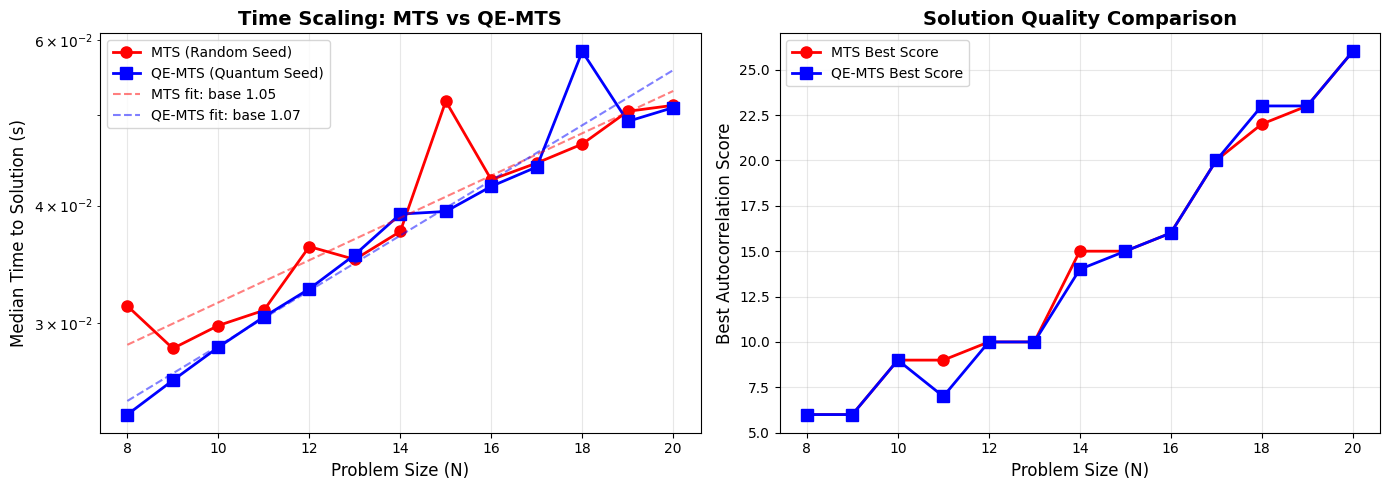


SCALING ANALYSIS
MTS scaling base: 1.0532
QE-MTS scaling base: 1.0700
Scaling advantage: 0.984x


In [17]:
# --------------------------
# Main
# --------------------------
if __name__ == "__main__":
    # Verify GPU target
    print(f"CUDA-Q target: {cudaq.get_target().name}")
    
    # Run scaling experiment
    df_scaling = scaling_experiment(
        N_values=[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        num_trials=50,
        quantum_shots=100
    )
    
    print(f"\n{'='*70}")
    print("RESULTS TABLE")
    print(f"{'='*70}")
    print(df_scaling.to_string(index=False))
    
    # Save results
    df_scaling.to_csv('labs_results.csv', index=False)
    
    plot_scaling(df_scaling)

CUDA-Q target: nvidia

N = 30
Running MTS (random seed)...
  Median time: 0.076s, Best score: 49.0
Running QE-MTS (quantum seed)...
  Median time: 0.075s, Best score: 51.0
  Speedup: 1.01x

RESULTS TABLE
 N  MTS_median_time  MTS_best_score  QE_MTS_median_time  QE_MTS_best_score  Speedup
30         0.076385            49.0            0.075336               51.0 1.013915


/tmp/ipykernel_49826/554495599.py:241: RankWarning: Polyfit may be poorly conditioned
  z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time'] + 1e-10), 1)
/tmp/ipykernel_49826/554495599.py:242: RankWarning: Polyfit may be poorly conditioned
  z_qe = np.polyfit(df['N'], np.log(df['QE_MTS_median_time'] + 1e-10), 1)


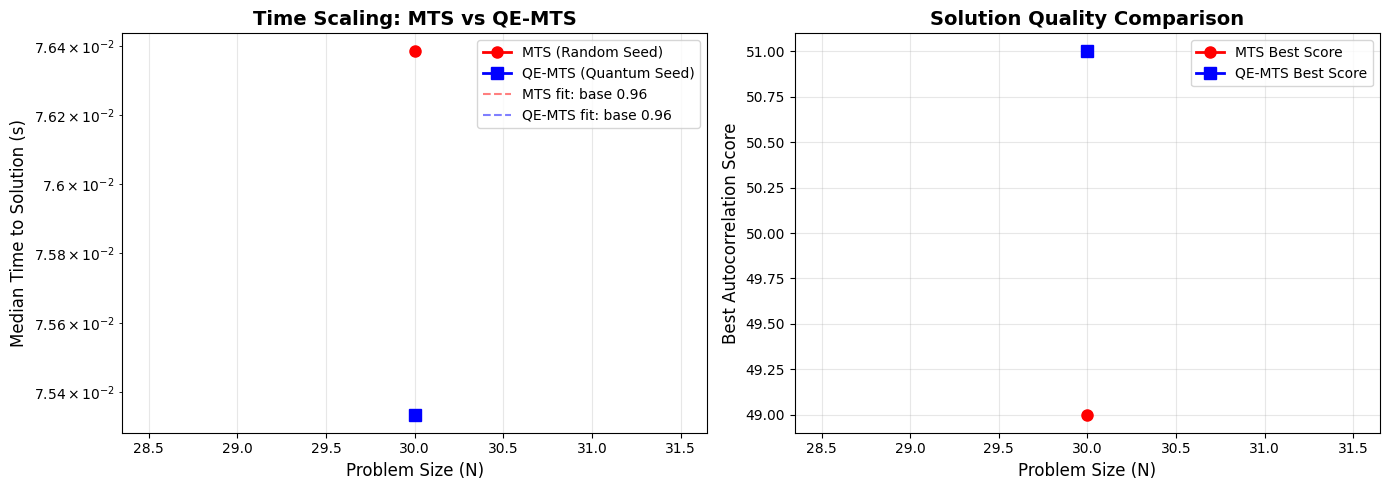


SCALING ANALYSIS
MTS scaling base: 0.9580
QE-MTS scaling base: 0.9578
Scaling advantage: 1.000x


In [18]:
# --------------------------
# Main
# --------------------------
if __name__ == "__main__":
    # Verify GPU target
    print(f"CUDA-Q target: {cudaq.get_target().name}")
    
    # Run scaling experiment
    df_scaling = scaling_experiment(
        N_values=[30],
        num_trials=50,
        quantum_shots=100
    )
    
    print(f"\n{'='*70}")
    print("RESULTS TABLE")
    print(f"{'='*70}")
    print(df_scaling.to_string(index=False))
    
    # Save results
    df_scaling.to_csv('labs_results_30.csv', index=False)
    
    plot_scaling(df_scaling)

CUDA-Q target: nvidia

N = 12
Running MTS (random seed)...
  Median time: 0.035s, Best energy: 14
Running QE-MTS (quantum seed)...
  Median time: 0.034s, Best energy: 14
  Speedup: 1.02x
  Energy improvement: 0.0%

RESULTS TABLE
 N  MTS_median_time  MTS_best_energy  QE_MTS_median_time  QE_MTS_best_energy  Speedup  Energy_improvement
12         0.034613             14.0            0.033827                14.0 1.023234                 0.0


/tmp/ipykernel_49826/1664850887.py:265: RankWarning: Polyfit may be poorly conditioned
  z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time'] + 1e-10), 1)
/tmp/ipykernel_49826/1664850887.py:266: RankWarning: Polyfit may be poorly conditioned
  z_qe = np.polyfit(df['N'], np.log(df['QE_MTS_median_time'] + 1e-10), 1)


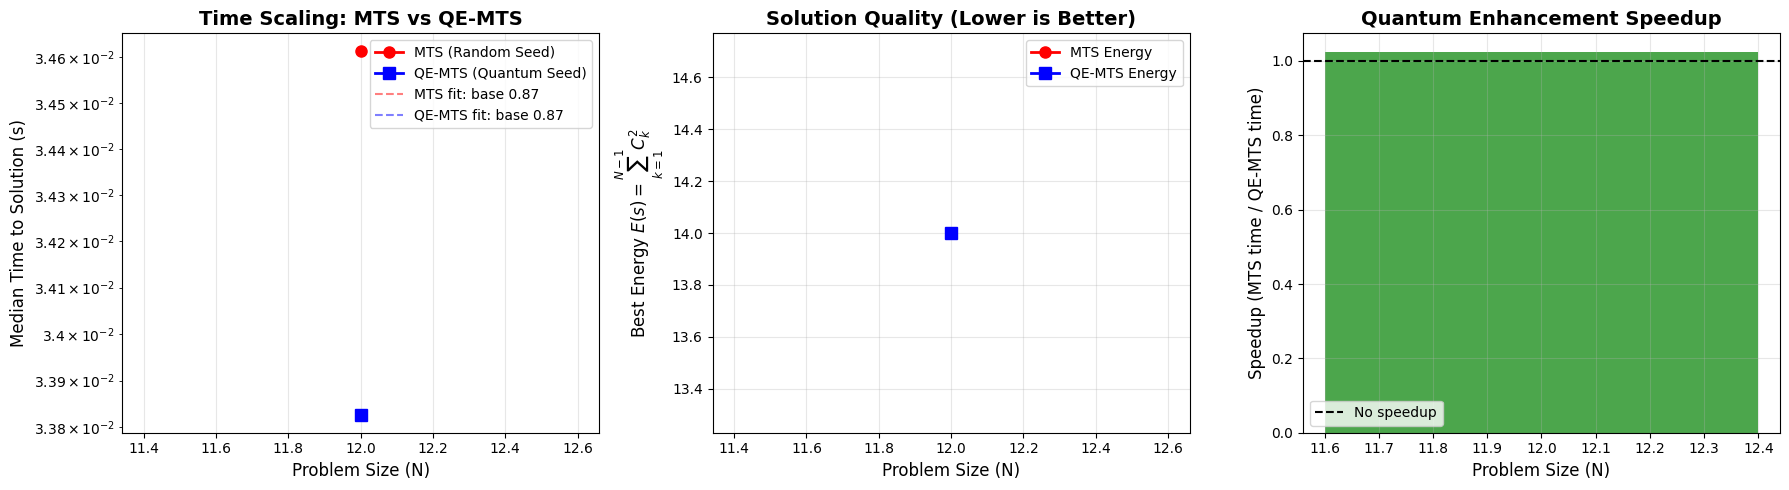


SCALING ANALYSIS
MTS scaling base: 0.8692
QE-MTS scaling base: 0.8684
Scaling advantage: 1.001x

Mean speedup: 1.02x
Mean energy improvement: 0.0%


In [25]:
import cudaq
import math
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

# Set GPU target for CUDA-Q
cudaq.set_target("nvidia")  # Use GPU acceleration

SEED = 120
np.random.seed(SEED)
random.seed(SEED)

# --------------------------
# Quantum Circuit (NN Trotter)
# --------------------------
@cudaq.kernel
def nn_trotter_circuit(N: int, thetas: list[float]):
    """
    Nearest-neighbor (NN) Trotterized circuit.
    'thetas' is a list of angles for each layer.
    """
    reg = cudaq.qvector(N)

    # Initial superposition: RX, RZ on all qubits
    for q in range(N):
        rx(math.pi / 2.0, reg[q])
        rz(math.pi / 2.0, reg[q])

    # NN Trotter layers - creates entanglement
    for theta in thetas:
        for q in range(N - 1):
            rx(theta, reg[q])
            cx(reg[q], reg[q + 1])
            rx(theta, reg[q + 1])
        # Add final layer connectivity
        rx(theta, reg[N - 1])

    mz(reg)

# --------------------------
# LABS Energy Function
# --------------------------
def labs_energy(sequence):
    """
    Compute LABS energy: E(s) = Σ_{k=1}^{N-1} C_k^2
    where C_k = Σ_{i=1}^{N-k} S_i * S_{i+k}
    
    Lower energy is better. Optimal sequences have minimal energy.
    """
    n = len(sequence)
    # Convert 0/1 binary to -1/+1 spin representation
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    
    energy = 0
    for k in range(1, n):  # k from 1 to N-1
        # C_k = autocorrelation at lag k
        c_k = np.sum(s[:n-k] * s[k:])
        energy += c_k ** 2
    
    return energy

def compute_autocorrelations(sequence):
    """
    Compute all autocorrelation values C_k for analysis.
    Returns dict with C_k values and total energy.
    """
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    
    correlations = {}
    for k in range(1, n):
        c_k = np.sum(s[:n-k] * s[k:])
        correlations[k] = c_k
    
    energy = sum(c**2 for c in correlations.values())
    return correlations, energy

# --------------------------
# LABS-Aware Theta Computation
# --------------------------
def compute_labs_theta(N, layer_idx, n_layers):
    """
    Compute theta for LABS problem.
    Uses annealing schedule: start with more exploration, end with exploitation.
    """
    anneal = 1.0 - (layer_idx / n_layers) * 0.5
    base_theta = np.pi / (N ** 0.5)
    return base_theta * anneal

# --------------------------
# Run Quantum Circuit
# --------------------------
def run_quantum_sampler(N, n_layers=3, shots=100):
    """
    Run the quantum circuit and return sampled bitstrings.
    """
    thetas = [compute_labs_theta(N, i, n_layers) for i in range(n_layers)]
    results = cudaq.sample(nn_trotter_circuit, N, thetas, shots_count=shots)
    
    sequences = []
    for bitstring, count in results.items():
        seq = [int(b) for b in bitstring]
        for _ in range(count):
            sequences.append(seq.copy())
    
    return sequences

# --------------------------
# Classical MTS Only
# --------------------------
def time_to_solution_mts_only(N, num_trials=5):
    """MTS with random initialization."""
    times = []
    best_energies = []

    for trial in range(num_trials):
        # Random population
        population = [list(np.random.randint(0, 2, N)) for _ in range(100)]
        energies = [labs_energy(seq) for seq in population]

        start_time = time.time()
        best_energy = min(energies)
        max_iters = 100000
        no_improve_count = 0

        for iteration in range(max_iters):
            idx = np.argmin(energies)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_energy = labs_energy(new_seq)

            if new_energy < best_energy:
                best_energy = new_energy
                population[idx] = new_seq
                energies[idx] = new_energy
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        elapsed = time.time() - start_time
        times.append(elapsed)
        best_energies.append(best_energy)

    return np.median(times), np.median(best_energies)

# --------------------------
# Quantum-Enhanced MTS
# --------------------------
def time_to_solution_qe_mts(N, quantum_shots=100, n_layers=3, num_trials=5):
    """MTS with quantum-seeded initial population."""
    times = []
    best_energies = []

    for trial in range(num_trials):
        # Quantum seeding
        quantum_seqs = run_quantum_sampler(N, n_layers=n_layers, shots=quantum_shots)
        
        # Build population: quantum samples + random fill
        population = quantum_seqs[:100]
        while len(population) < 100:
            population.append(list(np.random.randint(0, 2, N)))

        energies = [labs_energy(seq) for seq in population]

        # Classical MTS optimization
        start_time = time.time()
        best_energy = min(energies)
        max_iters = 10000
        no_improve_count = 0

        for iteration in range(max_iters):
            idx = np.argmin(energies)
            new_seq = population[idx].copy()
            flip_idx = np.random.randint(0, N)
            new_seq[flip_idx] = 1 - new_seq[flip_idx]

            new_energy = labs_energy(new_seq)

            if new_energy < best_energy:
                best_energy = new_energy
                population[idx] = new_seq
                energies[idx] = new_energy
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count > 500:
                break

        elapsed = time.time() - start_time
        times.append(elapsed)
        best_energies.append(best_energy)

    return np.median(times), np.median(best_energies)

# --------------------------
# Scaling Experiment
# --------------------------
def scaling_experiment(N_values, num_trials=5, quantum_shots=100):
    results = {
        'N': [],
        'MTS_median_time': [],
        'MTS_best_energy': [],
        'QE_MTS_median_time': [],
        'QE_MTS_best_energy': [],
        'Speedup': [],
        'Energy_improvement': []
    }

    for N in N_values:
        print(f"\n{'='*70}")
        print(f"N = {N}")
        print(f"{'='*70}")

        # MTS only
        print(f"Running MTS (random seed)...")
        mts_time, mts_energy = time_to_solution_mts_only(N, num_trials=num_trials)
        print(f"  Median time: {mts_time:.3f}s, Best energy: {mts_energy:.0f}")

        # QE-MTS
        print(f"Running QE-MTS (quantum seed)...")
        qe_time, qe_energy = time_to_solution_qe_mts(
            N, quantum_shots=quantum_shots, num_trials=num_trials
        )
        print(f"  Median time: {qe_time:.3f}s, Best energy: {qe_energy:.0f}")

        speedup = mts_time / qe_time if qe_time > 0 else 1.0
        energy_improvement = (mts_energy - qe_energy) / mts_energy * 100 if mts_energy > 0 else 0
        
        print(f"  Speedup: {speedup:.2f}x")
        print(f"  Energy improvement: {energy_improvement:.1f}%")

        results['N'].append(N)
        results['MTS_median_time'].append(mts_time)
        results['MTS_best_energy'].append(mts_energy)
        results['QE_MTS_median_time'].append(qe_time)
        results['QE_MTS_best_energy'].append(qe_energy)
        results['Speedup'].append(speedup)
        results['Energy_improvement'].append(energy_improvement)

    return pd.DataFrame(results)

# --------------------------
# Plot Scaling
# --------------------------
def plot_scaling(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Time scaling
    ax1 = axes[0]
    ax1.semilogy(df['N'], df['MTS_median_time'], 'o-', linewidth=2,
                 label='MTS (Random Seed)', markersize=8, color='red')
    ax1.semilogy(df['N'], df['QE_MTS_median_time'], 's-', linewidth=2,
                 label='QE-MTS (Quantum Seed)', markersize=8, color='blue')

    # Fit exponential curves
    z_mts = np.polyfit(df['N'], np.log(df['MTS_median_time'] + 1e-10), 1)
    z_qe = np.polyfit(df['N'], np.log(df['QE_MTS_median_time'] + 1e-10), 1)
    N_range = np.linspace(df['N'].min(), df['N'].max(), 100)
    
    ax1.semilogy(N_range, np.exp(z_mts[0] * N_range + z_mts[1]), '--',
                 alpha=0.5, color='red',
                 label=f'MTS fit: base {np.exp(z_mts[0]):.2f}')
    ax1.semilogy(N_range, np.exp(z_qe[0] * N_range + z_qe[1]), '--',
                 alpha=0.5, color='blue',
                 label=f'QE-MTS fit: base {np.exp(z_qe[0]):.2f}')

    ax1.set_xlabel('Problem Size (N)', fontsize=12)
    ax1.set_ylabel('Median Time to Solution (s)', fontsize=12)
    ax1.set_title('Time Scaling: MTS vs QE-MTS', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Energy comparison
    ax2 = axes[1]
    ax2.plot(df['N'], df['MTS_best_energy'], 'o-', linewidth=2,
             label='MTS Energy', markersize=8, color='red')
    ax2.plot(df['N'], df['QE_MTS_best_energy'], 's-', linewidth=2,
             label='QE-MTS Energy', markersize=8, color='blue')
    ax2.set_xlabel('Problem Size (N)', fontsize=12)
    ax2.set_ylabel(r'Best Energy $E(s) = \sum_{k=1}^{N-1} C_k^2$', fontsize=12)
    ax2.set_title('Solution Quality (Lower is Better)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Speedup
    ax3 = axes[2]
    ax3.bar(df['N'], df['Speedup'], color='green', alpha=0.7)
    ax3.axhline(y=1.0, color='black', linestyle='--', label='No speedup')
    ax3.set_xlabel('Problem Size (N)', fontsize=12)
    ax3.set_ylabel('Speedup (MTS time / QE-MTS time)', fontsize=12)
    ax3.set_title('Quantum Enhancement Speedup', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('labs_energy_results.png', dpi=150)
    plt.show()

    # Print analysis
    print(f"\n{'='*70}")
    print("SCALING ANALYSIS")
    print(f"{'='*70}")
    print(f"MTS scaling base: {np.exp(z_mts[0]):.4f}")
    print(f"QE-MTS scaling base: {np.exp(z_qe[0]):.4f}")
    if np.exp(z_qe[0]) > 0:
        print(f"Scaling advantage: {np.exp(z_mts[0]) / np.exp(z_qe[0]):.3f}x")
    print(f"\nMean speedup: {df['Speedup'].mean():.2f}x")
    print(f"Mean energy improvement: {df['Energy_improvement'].mean():.1f}%")
    print(f"{'='*70}")

# --------------------------
# Main
# --------------------------
if __name__ == "__main__":
    print(f"CUDA-Q target: {cudaq.get_target().name}")
    
    df_scaling = scaling_experiment(
        N_values=[ 12],
        num_trials=50,
        quantum_shots=200
    )
    
    print(f"\n{'='*70}")
    print("RESULTS TABLE")
    print(f"{'='*70}")
    print(df_scaling.to_string(index=False))
    
    df_scaling.to_csv('labs_energy_results.csv', index=False)
    plot_scaling(df_scaling)


In [42]:
# --------------------------
# LABS Energy Function
# --------------------------
def labs_energy(sequence):
    """
    Compute LABS energy: E(s) = Σ_{k=1}^{N-1} C_k^2
    where C_k = Σ_{i=1}^{N-k} S_i * S_{i+k}
    """
    n = len(sequence)
    s = np.array([1 if bit == 1 else -1 for bit in sequence])
    
    energy = 0
    for k in range(1, n):
        c_k = np.sum(s[:n-k] * s[k:])
        energy += c_k ** 2
    
    return energy

# Known optimal LABS energies for verification
KNOWN_OPTIMAL_ENERGY = {
    3: 1, 4: 2, 5: 2, 6: 4, 7: 4, 8: 4, 9: 6, 10: 6,
    11: 9, 12: 10, 13: 9, 14: 14, 15: 16, 16: 18,
    17: 19, 18: 22, 19: 24, 20: 24
}

# --------------------------
# Improved Classical MTS
# --------------------------
def time_to_solution_mts_only(N, num_trials=5):
    times = []
    energies = []
    best_sequences = []

    for _ in range(num_trials):
        # Larger population for better coverage
        population = [list(np.random.randint(0, 2, N)) for _ in range(200)]
        scores = [labs_energy(seq) for seq in population]

        start_time = time.time()
        best_idx = np.argmin(scores)
        best_score = scores[best_idx]
        best_seq = population[best_idx].copy()
        max_iters = 50000  # More iterations
        no_improve_count = 0

        for iteration in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            
            # Multi-bit flip: 1-bit (70%), 2-bit (25%), 3-bit (5%)
            rand_val = np.random.rand()
            if rand_val < 0.70:
                # Single bit flip
                flip_idx = np.random.randint(0, N)
                new_seq[flip_idx] = 1 - new_seq[flip_idx]
            elif rand_val < 0.95:
                # Two bit flip
                flip_indices = np.random.choice(N, 2, replace=False)
                for fi in flip_indices:
                    new_seq[fi] = 1 - new_seq[fi]
            else:
                # Three bit flip
                flip_indices = np.random.choice(N, min(3, N), replace=False)
                for fi in flip_indices:
                    new_seq[fi] = 1 - new_seq[fi]

            new_score = labs_energy(new_seq)

            if new_score < best_score:
                best_score = new_score
                best_seq = new_seq.copy()
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            elif new_score <= scores[idx] * 1.1:  # Accept slightly worse solutions
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count += 1
            else:
                no_improve_count += 1

            # Restart if stuck
            if no_improve_count > 2000:
                # Keep best, regenerate rest
                population = [best_seq.copy()] + [list(np.random.randint(0, 2, N)) for _ in range(199)]
                scores = [labs_energy(seq) for seq in population]
                no_improve_count = 0

            # Early termination if optimal found
            if N in KNOWN_OPTIMAL_ENERGY and best_score <= KNOWN_OPTIMAL_ENERGY[N]:
                break

        times.append(time.time() - start_time)
        energies.append(best_score)
        best_sequences.append(best_seq)

    best_trial_idx = np.argmin(energies)
    
    return np.median(times), min(energies), best_sequences[best_trial_idx]


# --------------------------
# Improved Quantum-Enhanced MTS
# --------------------------
def time_to_solution_qe_mts(N, quantum_shots=10, num_trials=5):
    times = []
    energies = []
    best_sequences = []

    for _ in range(num_trials):
        # Quantum Seeding
        dt = 1.0
        G2, G4 = get_interactions(N)
        thetas = [compute_theta(1.0, dt, 1.0, N, G2, G4)]
        counts = trotterized_circuit(N, G2, G4, 1, dt, 1.0, thetas)

        # Convert counts to population
        population = []
        for bitstring, count in counts.items():
            for _ in range(count):
                population.append([int(b) for b in bitstring])

        # Fill to 200
        while len(population) < 200:
            population.append(list(np.random.randint(0, 2, N)))

        scores = [labs_energy(seq) for seq in population]

        start_time = time.time()
        best_idx = np.argmin(scores)
        best_score = scores[best_idx]
        best_seq = population[best_idx].copy()
        max_iters = 50000
        no_improve_count = 0

        for iteration in range(max_iters):
            idx = np.argmin(scores)
            new_seq = population[idx].copy()
            
            # Multi-bit flip
            rand_val = np.random.rand()
            if rand_val < 0.70:
                flip_idx = np.random.randint(0, N)
                new_seq[flip_idx] = 1 - new_seq[flip_idx]
            elif rand_val < 0.95:
                flip_indices = np.random.choice(N, 2, replace=False)
                for fi in flip_indices:
                    new_seq[fi] = 1 - new_seq[fi]
            else:
                flip_indices = np.random.choice(N, min(3, N), replace=False)
                for fi in flip_indices:
                    new_seq[fi] = 1 - new_seq[fi]

            new_score = labs_energy(new_seq)

            if new_score < best_score:
                best_score = new_score
                best_seq = new_seq.copy()
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count = 0
            elif new_score <= scores[idx] * 1.1:
                population[idx] = new_seq
                scores[idx] = new_score
                no_improve_count += 1
            else:
                no_improve_count += 1

            if no_improve_count > 2000:
                population = [best_seq.copy()] + [list(np.random.randint(0, 2, N)) for _ in range(199)]
                scores = [labs_energy(seq) for seq in population]
                no_improve_count = 0

            if N in KNOWN_OPTIMAL_ENERGY and best_score <= KNOWN_OPTIMAL_ENERGY[N]:
                break

        times.append(time.time() - start_time)
        energies.append(best_score)
        best_sequences.append(best_seq)

    best_trial_idx = np.argmin(energies)
    
    return np.median(times), min(energies), best_sequences[best_trial_idx]


# --------------------------
# Scaling Experiment (with optimal comparison)
# --------------------------
def scaling_experiment(N_values=[8, 10, 12], num_trials=3):
    results = {
        'N': [],
        'Optimal_energy': [],
        'MTS_median_time': [],
        'MTS_best_energy': [],
        'QE_MTS_median_time': [],
        'QE_MTS_best_energy': [],
        'Speedup': [],
        'MTS_gap_to_optimal': [],
        'QE_MTS_gap_to_optimal': []
    }

    for N in N_values:
        print(f"\n{'='*70}")
        print(f"N = {N}")
        optimal = KNOWN_OPTIMAL_ENERGY.get(N, "Unknown")
        print(f"Known optimal energy: {optimal}")
        print(f"{'='*70}")

        # MTS only
        print(f"Running MTS (random seed)...")
        mts_time, mts_energy, mts_best_seq = time_to_solution_mts_only(N, num_trials=num_trials)
        print(f"  Median time: {mts_time:.3f}s")
        print(f"  Best energy E(s): {mts_energy:.0f}")
        print(f"  Best sequence: {''.join(map(str, mts_best_seq))}")

        # QE-MTS
        print(f"Running QE-MTS (quantum seed)...")
        qe_time, qe_energy, qe_best_seq = time_to_solution_qe_mts(N, quantum_shots=10, num_trials=num_trials)
        print(f"  Median time: {qe_time:.3f}s")
        print(f"  Best energy E(s): {qe_energy:.0f}")
        print(f"  Best sequence: {''.join(map(str, qe_best_seq))}")

        # Calculate metrics
        speedup = mts_time / qe_time if qe_time > 0 else 1.0
        
        if isinstance(optimal, int):
            mts_gap = ((mts_energy - optimal) / optimal) * 100
            qe_gap = ((qe_energy - optimal) / optimal) * 100
            print(f"  MTS gap to optimal: {mts_gap:.1f}%")
            print(f"  QE-MTS gap to optimal: {qe_gap:.1f}%")
        else:
            mts_gap = None
            qe_gap = None
            
        print(f"  Speedup: {speedup:.2f}x")

        results['N'].append(N)
        results['Optimal_energy'].append(optimal)
        results['MTS_median_time'].append(mts_time)
        results['MTS_best_energy'].append(mts_energy)
        results['QE_MTS_median_time'].append(qe_time)
        results['QE_MTS_best_energy'].append(qe_energy)
        results['Speedup'].append(speedup)
        results['MTS_gap_to_optimal'].append(mts_gap)
        results['QE_MTS_gap_to_optimal'].append(qe_gap)

    return pd.DataFrame(results)